## Questions

Are students asking conceptual or appllied questions?
Which topics are more prevalent? Where is the most confusion?
    - Topic Modeling
    - Run the same topic model over different intervals of time
What do in-person interactions not already tell us? 
What are areas that need attention in student understanding? 
    - Concrete evidence of topics where students are struggling
Probably don't look at response time
What are people afraid of asking about? (Anonymous posts from students)
Data:
    - Timestamp
    - Userid (student or instructor, throw out announcements)
    - Question or answer? 
    - Votes (good question)
    - Question Text

    
diff values of config?
Check status = active
transform to get length of upvote_ids

Question or Answer? 
Num votes/good question
where does anon equal yes

In [1]:
import glob
import pickle
import pandas as pd
import numpy as np
import scipy
import nltk
import re
import random

from typing import List, Tuple
from collections import OrderedDict

from wordcloud import WordCloud
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation 

In [2]:
dfs = glob.glob('data/dataframes/*.p')

In [3]:
# Are these the correct names for Danielle's classes?  (2,3,4)
# This is done to ensure that the classes dataframes are read in chronological order, not by the order
# in which the file paths appear in our file system
id_class_map = {}
id_class_map['iqv0bsb3p2i3ch'] = 'Fall 2016 Dewan'
id_class_map['j5wwaj87hvu6af'] = 'Fall 2017 KMP'
id_class_map['jz8ejj1lawb5st'] = 'Spring 2019 Dewan'
id_class_map['jqnyuvgzug4p3'] = 'Spring 2019 KMP'
id_class_map['jkws0l0gvcr7it'] = 'Fall 2019 KMP'

ordered_dfs = [] 
for i in id_class_map:
    for df in dfs:
        if i in df:
            ordered_dfs.append(df)
            
dfs = ordered_dfs
network_ids = [re.search(r'dataframe_(.*?)\.p', file_path).group(1) for file_path in dfs]

In [4]:
# Auxiliary LDA Functions
def print_topics(model, vectorizer, top_n: int=10)-> List: 
    """Print the top n words found by each topic model.
    
    Args:
        model: Sklearn LatentDirichletAllocation model
        vectorizer: sklearn CountVectorizer
        top_n (int): Number of words you wish to return 
        
    Source: https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0
    
    """
    for idx, topic in enumerate(model.components_):
        print("Topic %d:" % (idx))
        print([(vectorizer.get_feature_names()[i], topic[i])
                        for i in topic.argsort()[:-top_n - 1:-1]])
        
    return [vectorizer.get_feature_names()[i] for i in topic.argsort()[:-top_n-1:-1]]
        
def lda_operation(data_samples, num_features: int=400, num_topics: int=6)-> Tuple: 
    """Performs Latent Dirichlet Allocation on a list of our text samles 
    
    Args:
        data_samples List[str]: List of strings representing the text of each Piazza post
        num_features (int): Max number of features to be considered by term frequency
        num_topics (int): Number of topics 
    
    Returns:
        tuple: Trained LDA Model and the embedded text in the CountVectorizer
        
    """
    
    tf_vectorizer = CountVectorizer(max_df=.85, min_df=.05, max_features=num_features, stop_words='english', token_pattern=u'(?ui)\\b\\w\w*[a-z]+\\w*\\b')
    
    tf_data_samples = tf_vectorizer.fit_transform(data_samples) 
    tf_feature_names = tf_vectorizer.get_feature_names()

    lda = LatentDirichletAllocation(n_components=num_topics, max_iter=100, learning_method='online', learning_offset=10.,random_state=1).fit(tf_data_samples)
    lda.score(tf_data_samples)

    return lda, tf_vectorizer

def save_topics(model, vectorizer, top_n: int=10)-> List:
    """ Save the top n topics from our trained model
    
    Args:
        model: Sklearn LatentDirichletAllocation model
        vectorizer: sklearn CountVectorizer
        top_n (int): Number of topics
    
    Returns:
        list: A list of the top_n words for each topic 
        
    """
    words_per_topic = []
    for idx, topic in enumerate(model.components_):
        words = [vectorizer.get_feature_names()[i] for i in topic.argsort()[:-top_n-1:-1]]
        words_per_topic.append(words)
        
    return words_per_topic

In [5]:
all_dfs = [] # The un-pickled posts for each 401 Class
lda_output = [] # The output of every LDA model 
all_topic_words = [] # All of the top_n topics for each LDA model 

# Run LDA on the text of every 401 class' posts
for i in range(len(dfs)):
    current_df = pd.read_pickle(dfs[i])
    
    # Adding on new features 
    current_df['word_count'] = current_df['text'].map(lambda x: len(x))    
        
    all_dfs.append(current_df)
    
    data_list = current_df["text"].tolist()
    lda_output.append(lda_operation(data_list))
    
# Save all of the words found by the topic model for each class
for output in lda_output:
#     print_topics(*output)
    all_topic_words.append(save_topics(*output))

In [6]:
# all_text[0] (text of Fall 2016 posts) has mostly java stack traces
all_text = [''.join(df['text'].tolist()) for df in all_dfs]
all_text = [re.sub(r'(?ui)\\b\\w\w*[a-z]+\\w*\\b', '', text) for text in all_text]

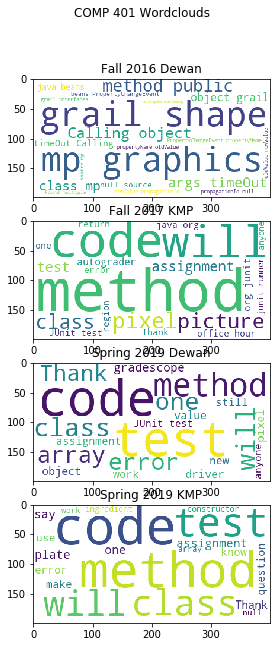

In [7]:
# Plot word clouds of all the currently completed 401 classes
fig, axs = plt.subplots(nrows=4, figsize=(10, 10))
fig.suptitle("COMP 401 Wordclouds")

for i in range(0, 4):
    wordcloud = WordCloud(background_color="white", max_words=20, contour_width=3, contour_color='steelblue')
    wordcloud.generate(all_text[i])
    axs[i].imshow(wordcloud)
    axs[i].set_title(id_class_map[network_ids[i]])

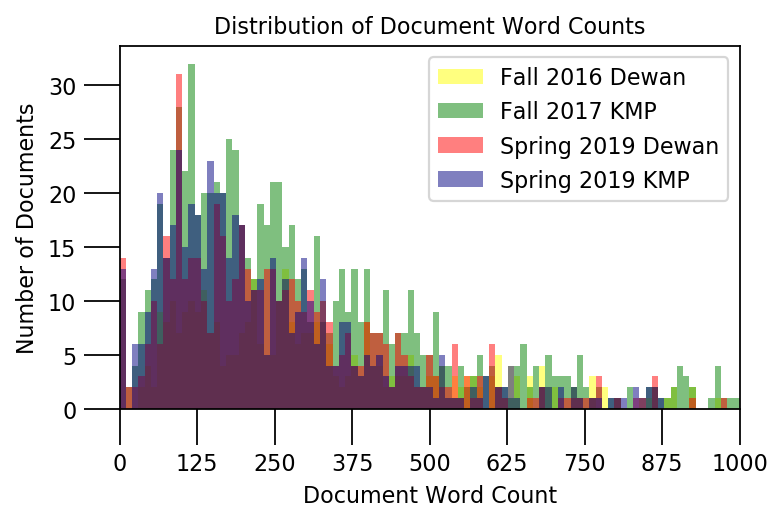

In [8]:
# Plot the distribution of word counts for all completed 401 classes that we have
bins = np.linspace(0, 1000, 100)
colors = ['yellow', 'green', 'red', 'navy']

plt.figure(figsize=(5, 3), dpi=160)
for i in range(len(all_dfs)-1):
    plt.hist(all_dfs[i]['word_count'], bins, color=colors[i], alpha=.5, label=id_class_map[network_ids[i]])
    # plt.hist(word_counts_by_class, bins, color=colors, alpha=.5, label=list(class_names.values()))
# plt.text(700,  60, "Mean   : " + str(round(np.mean(counts))))
# plt.text(700,  50, "Median : " + str(round(np.median(counts))))
# plt.text(700,  40, "Stdev   : " + str(round(np.std(counts))))
# plt.text(700,  30, "1%ile    : " + str(round(np.quantile(counts, q=0.01))))
# plt.text(700,  20, "99%ile  : " + str(round(np.quantile(counts, q=0.99))))

plt.gca().set(xlim=(0, 1000), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=16)
plt.legend(loc='upper right')
plt.xticks(np.linspace(0, 1000, 9))
plt.title('Distribution of Document Word Counts', fontdict=dict(size=10))
plt.show()

/Users/lexokan/opt/anaconda3/envs/piazza/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: You have used the `textcoords` kwarg, but not the `xytext` kwarg.  This can lead to surprising results.


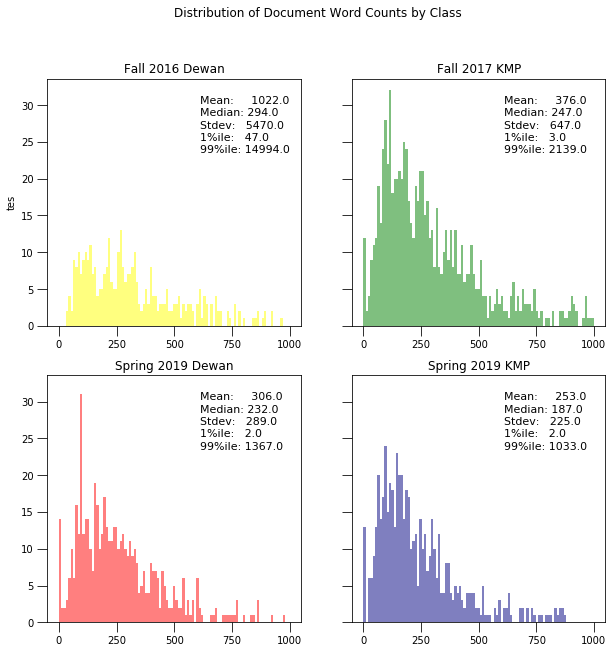

In [9]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 10), sharey=True)
fig.suptitle("Distribution of Document Word Counts by Class")

axs = axs.flatten()
for i in range(len(all_dfs)-1):
    axs[i].hist(all_dfs[i]['word_count'], bins, color=colors[i], alpha=.5)
    axs[i].set_title(id_class_map[network_ids[i]])
    
    # Computation of Summary Statistics
    summary_stats = {}
    summary_stats['Mean'] = str(round(np.mean(all_dfs[i]['word_count'])))
    summary_stats['Median'] = str(round(np.median(all_dfs[i]['word_count'])))
    summary_stats['Stdev'] = str(round(np.std(all_dfs[i]['word_count'])))
    summary_stats['1%ile'] = str(round(np.quantile(all_dfs[i]['word_count'], q=0.01)))
    summary_stats['99%ile'] = str(round(np.quantile(all_dfs[i]['word_count'], q=0.99)))

    starting_y = .90
    # get max length of the key and add diff as offset
    for k, v in summary_stats.items():
        axs[i].annotate(
            k +': ' + ''.join(' ' * (2*(6-len(k)))) + v,
            (.60, starting_y),
            textcoords='axes fraction',
            size=11)
        
        starting_y -= .05
    
    axs[i].tick_params(size=10)
    axs[i].set_xticks(np.linspace(0, 1000, 5))
    
axs[0].set_ylabel("tes")
plt.show()

In [10]:
# TODO: Average word count over time for each class
def sorted_word_count(df): 
    df = df.copy()
    df['created'] = df['created'].dt.date
    
    return (df[['created', 'word_count']]
     .groupby('created')
     .agg('mean')
     .reset_index()
     .sort_values(by='created'))
sorted_word_counts = [sorted_word_count(df) for df in all_dfs]

/Users/lexokan/opt/anaconda3/envs/piazza/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


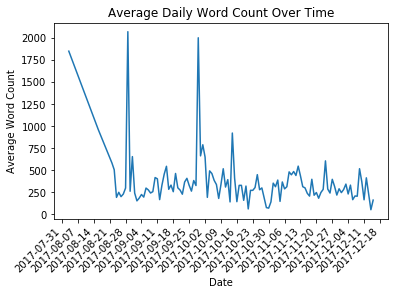

In [11]:
import matplotlib.dates as mdates

wc_1 = sorted_word_counts[1]
weeks = mdates.WeekdayLocator(byweekday=mdates.MO)
fig, ax = plt.subplots()

ax.plot(wc_1['created'], wc_1['word_count'])
ax.xaxis.set_major_locator(weeks)

plt.gcf().autofmt_xdate()

# format the coords message box
plt.xticks(rotation=45)
plt.ylabel("Average Word Count")
plt.xlabel("Date")
plt.title("Average Daily Word Count Over Time")
plt.show()

In [12]:
# TODO: t_SNE

In [13]:
# TODO: Bar chart of top words for topics

In [14]:
# TODO: Maybe add another feature for how many children are in each comment (how responsive are people on piazza)
# or is this already encoded into anothe feld

https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0
https://www.machinelearningplus.com/nlp/topic-modeling-visualization-how-to-present-results-lda-models/